In [1]:
from utils import *

import folium
import geopandas as gpd

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_log_error, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

from xgboost import XGBRegressor

## Data description

In [2]:
macro_df = pd.read_csv('data/macro.csv', parse_dates=['timestamp'])
train_df = pd.read_csv('data/train.csv', index_col='id', parse_dates=['timestamp'])
test_df = pd.read_csv('data/test.csv', index_col='id', parse_dates=['timestamp'])
tverskoe_issue_fix(train_df)
tverskoe_issue_fix(test_df)

Fix:  550
Fix:  149


## 1. Data preprocessing
## I part (encoding and correcting mistakes)

### Macro dataset

In [3]:
macro_df['child_on_acc_pre_school'] = macro_df['child_on_acc_pre_school'].str.replace('#!', 'nan')
for column in macro_df.select_dtypes('object').columns:
    macro_df[column] = macro_df[column].str.replace(',', '.')
    macro_df[column] = macro_df[column].astype(float)

if not len(macro_df.select_dtypes('object').columns):
    print('OK')

OK


### Train dataset

In [4]:
train_df = encode(train_df)

### Test dataset

In [5]:
test_df = encode(test_df)

## II part (Filling missing values)

XGBRegressor model handles `np.NaN` values itself

## 2. Encoding `sub_area` feature

In [6]:
train_df['is_train'] = 1
test_df['is_train'] = 0

coords_df = pd.read_csv('data/coords.csv', index_col='id')
all_df = pd.concat([train_df, test_df])

all_df['latitude'] = coords_df['latitude']
all_df['longitude'] = coords_df['longitude']

## 3. Removing outliers

In [7]:
all_df = remove_outliers(all_df)

In [8]:
train_df = all_df[all_df['is_train'] == 1].drop(['is_train'], axis=1)
test_df = all_df[all_df['is_train'] == 0].drop(['is_train', 'price_doc'], axis=1)

In [9]:
X = train_df.drop(['sub_area', 'price_doc'], axis=1).copy()
y = np.log1p(train_df['price_doc'])
X_test = test_df.drop(['sub_area'], axis=1).copy()

In [10]:
y_pred_val = []
y_pred_train = []
kf = KFold(n_splits=5, shuffle=True, random_state=42)
kf_splits = kf.split(X)

params = {'objective': 'reg:squarederror',
          'n_estimators': 10000,
          'tree_method': 'gpu_hist',
          'booster': 'gbtree',
          'base_score': 7,
          'learning_rate': 0.05,
          'max_depth': 4,
          'min_child_weight': 7,
          'subsample': 1,
          'colsample_bytree': 0.9,
          'reg_lambda': 5,
          'reg_alpha': 1,
          'eval_metric': 'rmse',
          'seed': 42,
          'nthread': -1
          }

for train_index, val_index in kf_splits:
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    model = XGBRegressor(**params)
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], early_stopping_rounds=50)
    y_pred_train.append(model.predict(X_train))
    y_pred_val.append(model.predict(X_val))

[0]	validation_0-rmse:8.20378	validation_1-rmse:8.19001
[1]	validation_0-rmse:7.79567	validation_1-rmse:7.78230
[2]	validation_0-rmse:7.40813	validation_1-rmse:7.39491
[3]	validation_0-rmse:7.03993	validation_1-rmse:7.02689
[4]	validation_0-rmse:6.69021	validation_1-rmse:6.67740
[5]	validation_0-rmse:6.35818	validation_1-rmse:6.34557
[6]	validation_0-rmse:6.04272	validation_1-rmse:6.03043
[7]	validation_0-rmse:5.74310	validation_1-rmse:5.73103
[8]	validation_0-rmse:5.45855	validation_1-rmse:5.44680
[9]	validation_0-rmse:5.18833	validation_1-rmse:5.17683
[10]	validation_0-rmse:4.93174	validation_1-rmse:4.92050
[11]	validation_0-rmse:4.68805	validation_1-rmse:4.67695
[12]	validation_0-rmse:4.45669	validation_1-rmse:4.44585
[13]	validation_0-rmse:4.23700	validation_1-rmse:4.22634
[14]	validation_0-rmse:4.02843	validation_1-rmse:4.01804
[15]	validation_0-rmse:3.83046	validation_1-rmse:3.82018
[16]	validation_0-rmse:3.64249	validation_1-rmse:3.63241
[17]	validation_0-rmse:3.46406	validation

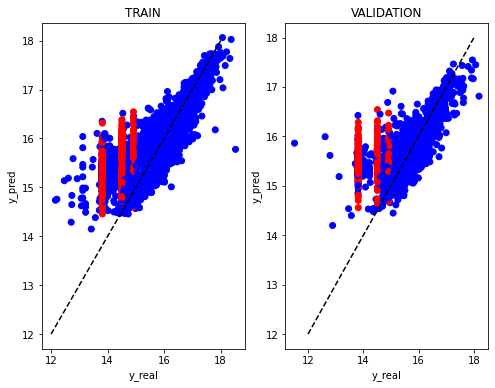

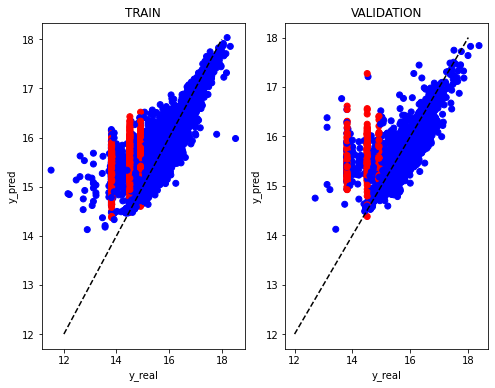

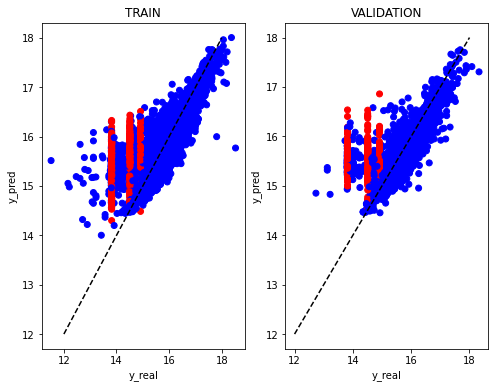

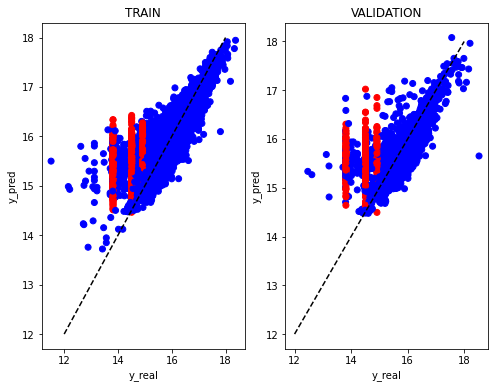

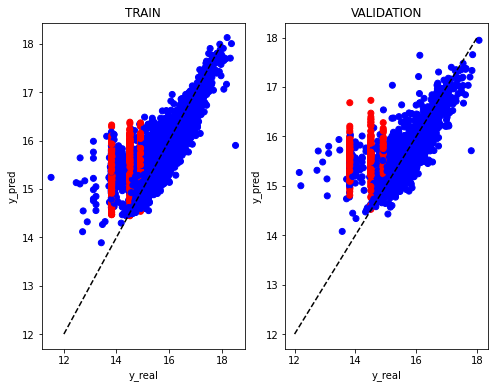

In [11]:
train_errors = []
val_errors = []
kf = KFold(n_splits=5, shuffle=True, random_state=42)
kf_splits = kf.split(X)

for i, (train_index, val_index) in enumerate(kf_splits):
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    # train_errors.append(np.abs(y_pred_train[i] - y_train) / np.abs(y_train))
    # val_errors.append(np.abs(y_pred_val[i] - y_val) / np.abs(y_val))
    train_errors.append(np.square(y_pred_train[i] - y_train))
    val_errors.append(np.square(y_pred_val[i] - y_val))


    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 6))

    mask_fake_prices = (y_train == np.log1p(1_000_000)) | \
                       (y_train == np.log1p(2_000_000)) | \
                       (y_train == np.log1p(3_000_000))
    ax1.scatter(y_train, y_pred_train[i], cmap='bwr', c=mask_fake_prices)
    ax1.plot(np.linspace(12, 18, 100), np.linspace(12, 18, 100), c='black', linestyle='--')
    ax1.set_title('TRAIN')
    ax1.set_xlabel('y_real')
    ax1.set_ylabel('y_pred')

    mask_fake_prices = (y_val == np.log1p(1_000_000)) | \
                       (y_val == np.log1p(2_000_000)) | \
                       (y_val == np.log1p(3_000_000))
    ax2.scatter(y_val, y_pred_val[i], cmap='bwr', c=mask_fake_prices)
    ax2.plot(np.linspace(12, 18, 100), np.linspace(12, 18, 100), c='black', linestyle='--')
    ax2.set_title('VALIDATION')
    ax2.set_xlabel('y_real')
    ax2.set_ylabel('y_pred')

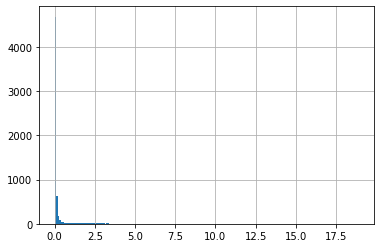

In [31]:
val_errors[0].hist(bins=200);

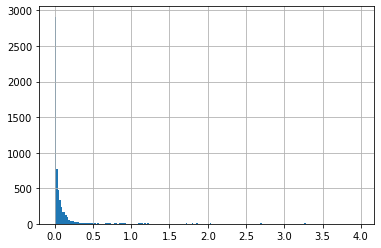

In [32]:
val_errors[0][val_errors[0] < 4].hist(bins=200);

In [99]:
idx_outliers = []

for train_error in train_errors:
    idx_outliers.append(train_error[train_error > 4].index.values)

for val_error in val_errors:
    idx_outliers.append(val_error[val_error > 4].index.values)

idx_outliers = np.concatenate(idx_outliers)
idx_outliers = np.unique(idx_outliers)

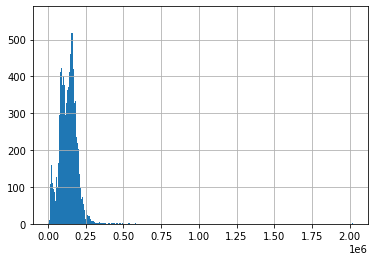

In [100]:
(all_df['price_doc'] / all_df['full_sq']).hist(bins=1000);

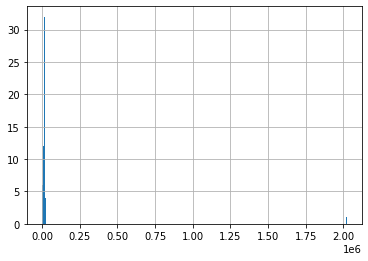

In [101]:
price_sqm = all_df.loc[idx_outliers, 'price_doc'] / all_df.loc[idx_outliers, 'full_sq']
price_sqm.hist(bins=1000);

In [102]:
price_sqm[price_sqm > 50000]

id
2121     2.020202e+06
16746    1.789206e+06
dtype: float64

In [98]:
# price_sqm = all_df.loc[idx_outliers, 'price_doc'] / all_df.loc[idx_outliers, 'full_sq']
# price_sqm.hist(bins=1000);
# all_df.loc[idx_outliers]['price_doc'] == 1_000_000
# all_df.loc[idx_outliers].loc[all_df.loc[idx_outliers]['price_doc'] == 1_000_000].sub_area

In [103]:
idx_outliers

array([   84,    97,   217,   294,   365,   366,   499,   635,   646,
         744,   802,   811,   842,   855,  1030,  1078,  1150,  1168,
        1170,  1264,  1312,  1381,  1491,  1524,  1582,  1599,  1625,
        1727,  1838,  1963,  1964,  1981,  2070,  2076,  2100,  2102,
        2121,  2341,  2513,  2525,  2553,  2631,  2680,  2796,  3122,
        3261,  3354,  3607,  3874,  4533,  6049,  6751,  7190,  7490,
        8424,  8904,  9095,  9153,  9224,  9873,  9949, 10219, 10488,
       11539, 11595, 11744, 11898, 11926, 12029, 12359, 12395, 12396,
       12597, 12620, 12664, 12755, 13096, 13263, 13386, 13408, 13487,
       13905, 14262, 14387, 14412, 14441, 14520, 15025, 15136, 15475,
       15494, 15748, 15840, 16117, 16181, 16225, 16499, 16520, 16716,
       16746, 16822, 16936, 17018, 17176, 17224, 17339, 17620, 17747,
       17892, 18580, 18850, 18976, 19021, 19252, 19305, 19374, 19641,
       19666, 19749, 19935, 19951, 19977, 20023, 20206, 20247, 20391,
       20896, 21022,

In [106]:
X = X.drop(idx_outliers)

In [108]:
y = y.drop(idx_outliers)

In [109]:
y_pred_val = []
y_pred_train = []
kf = KFold(n_splits=5, shuffle=True, random_state=42)
kf_splits = kf.split(X)

params = {'objective': 'reg:squarederror',
          'n_estimators': 10000,
          'tree_method': 'gpu_hist',
          'booster': 'gbtree',
          'base_score': 7,
          'learning_rate': 0.05,
          'max_depth': 4,
          'min_child_weight': 7,
          'subsample': 1,
          'colsample_bytree': 0.9,
          'reg_lambda': 5,
          'reg_alpha': 1,
          'eval_metric': 'rmse',
          'seed': 42,
          'nthread': -1
          }

for train_index, val_index in kf_splits:
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    model = XGBRegressor(**params)
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], early_stopping_rounds=50)
    y_pred_train.append(model.predict(X_train))
    y_pred_val.append(model.predict(X_val))

[0]	validation_0-rmse:8.20868	validation_1-rmse:8.21594
[1]	validation_0-rmse:7.80013	validation_1-rmse:7.80773
[2]	validation_0-rmse:7.41221	validation_1-rmse:7.41974
[3]	validation_0-rmse:7.04360	validation_1-rmse:7.05144
[4]	validation_0-rmse:6.69351	validation_1-rmse:6.70146
[5]	validation_0-rmse:6.36110	validation_1-rmse:6.36901
[6]	validation_0-rmse:6.04527	validation_1-rmse:6.05325
[7]	validation_0-rmse:5.74529	validation_1-rmse:5.75363
[8]	validation_0-rmse:5.46039	validation_1-rmse:5.46886
[9]	validation_0-rmse:5.18982	validation_1-rmse:5.19839
[10]	validation_0-rmse:4.93288	validation_1-rmse:4.94156
[11]	validation_0-rmse:4.68884	validation_1-rmse:4.69763
[12]	validation_0-rmse:4.45713	validation_1-rmse:4.46598
[13]	validation_0-rmse:4.23709	validation_1-rmse:4.24606
[14]	validation_0-rmse:4.02817	validation_1-rmse:4.03718
[15]	validation_0-rmse:3.82986	validation_1-rmse:3.83898
[16]	validation_0-rmse:3.64153	validation_1-rmse:3.65061
[17]	validation_0-rmse:3.46276	validation

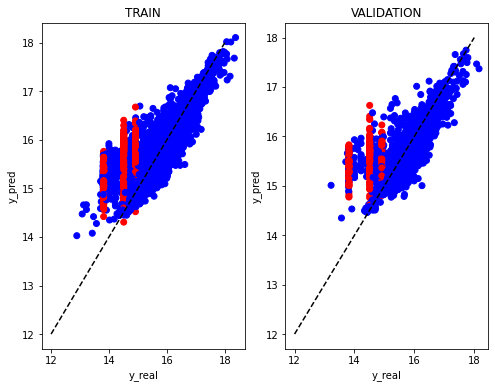

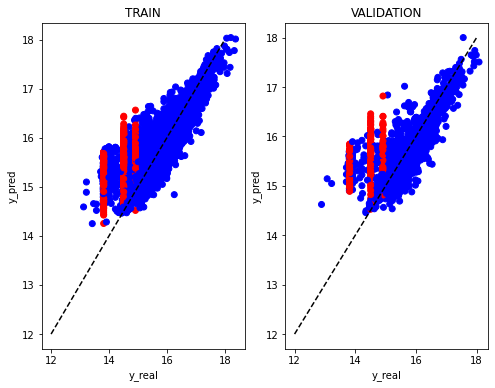

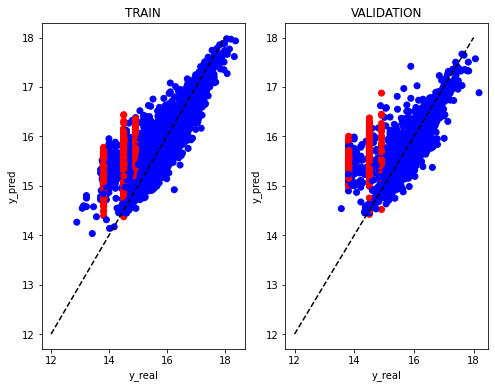

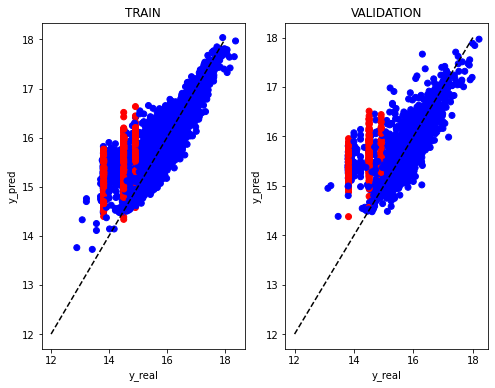

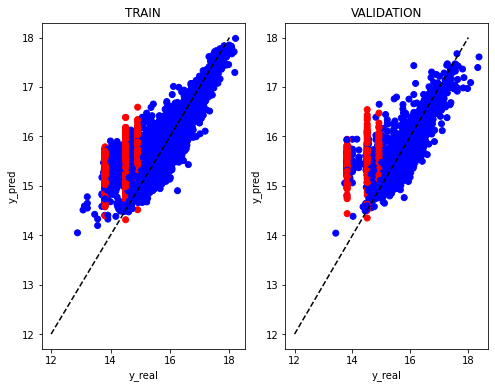

In [110]:
train_errors = []
val_errors = []
kf = KFold(n_splits=5, shuffle=True, random_state=42)
kf_splits = kf.split(X)

for i, (train_index, val_index) in enumerate(kf_splits):
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    # train_errors.append(np.abs(y_pred_train[i] - y_train) / np.abs(y_train))
    # val_errors.append(np.abs(y_pred_val[i] - y_val) / np.abs(y_val))
    train_errors.append(np.square(y_pred_train[i] - y_train))
    val_errors.append(np.square(y_pred_val[i] - y_val))


    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 6))

    mask_fake_prices = (y_train == np.log1p(1_000_000)) | \
                       (y_train == np.log1p(2_000_000)) | \
                       (y_train == np.log1p(3_000_000))
    ax1.scatter(y_train, y_pred_train[i], cmap='bwr', c=mask_fake_prices)
    ax1.plot(np.linspace(12, 18, 100), np.linspace(12, 18, 100), c='black', linestyle='--')
    ax1.set_title('TRAIN')
    ax1.set_xlabel('y_real')
    ax1.set_ylabel('y_pred')

    mask_fake_prices = (y_val == np.log1p(1_000_000)) | \
                       (y_val == np.log1p(2_000_000)) | \
                       (y_val == np.log1p(3_000_000))
    ax2.scatter(y_val, y_pred_val[i], cmap='bwr', c=mask_fake_prices)
    ax2.plot(np.linspace(12, 18, 100), np.linspace(12, 18, 100), c='black', linestyle='--')
    ax2.set_title('VALIDATION')
    ax2.set_xlabel('y_real')
    ax2.set_ylabel('y_pred')

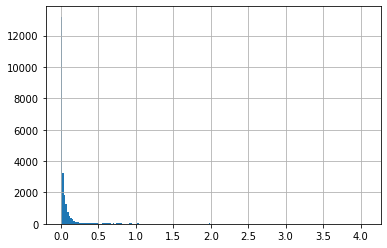

In [115]:
train_errors[3].hist(bins=200);

In [116]:
idx_outliers_2 = []

for train_error in train_errors:
    idx_outliers_2.append(train_error[train_error > 2].index.values)

for val_error in val_errors:
    idx_outliers_2.append(val_error[val_error > 2].index.values)

idx_outliers_2 = np.concatenate(idx_outliers_2)
idx_outliers_2 = np.unique(idx_outliers_2)

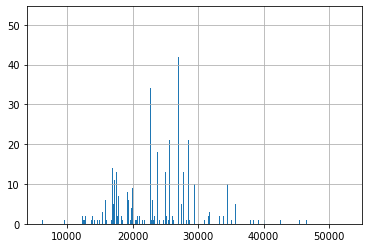

In [118]:
price_sqm = all_df.loc[idx_outliers_2, 'price_doc'] / all_df.loc[idx_outliers_2, 'full_sq']
price_sqm.hist(bins=1000);

In [123]:
# all_df.loc[idx_outliers_2, 'product_type'].sum()

In [ ]:
# price_sqm = all_df.loc[idx_outliers, 'price_doc'] / all_df.loc[idx_outliers, 'full_sq']
# price_sqm.hist(bins=1000);
# all_df.loc[idx_outliers]['price_doc'] == 1_000_000
# all_df.loc[idx_outliers].loc[all_df.loc[idx_outliers]['price_doc'] == 1_000_000].sub_area

In [126]:
all_df.loc[idx_outliers_2, 'product_type'].sum()

0.0

In [127]:
all_df.loc[idx_outliers, 'product_type'].sum()

4.0

In [131]:
idx_outliers_full = np.append(idx_outliers, idx_outliers_2)
len(idx_outliers_full)

1119

In [132]:
X = X.drop(idx_outliers_2)
y = y.drop(idx_outliers_2)

In [133]:
y_pred_val = []
y_pred_train = []
kf = KFold(n_splits=5, shuffle=True, random_state=42)
kf_splits = kf.split(X)

params = {'objective': 'reg:squarederror',
          'n_estimators': 10000,
          'tree_method': 'gpu_hist',
          'booster': 'gbtree',
          'base_score': 7,
          'learning_rate': 0.05,
          'max_depth': 4,
          'min_child_weight': 7,
          'subsample': 1,
          'colsample_bytree': 0.9,
          'reg_lambda': 5,
          'reg_alpha': 1,
          'eval_metric': 'rmse',
          'seed': 42,
          'nthread': -1
          }

for train_index, val_index in kf_splits:
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    model = XGBRegressor(**params)
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], early_stopping_rounds=50)
    y_pred_train.append(model.predict(X_train))
    y_pred_val.append(model.predict(X_val))

[0]	validation_0-rmse:8.25459	validation_1-rmse:8.26172
[1]	validation_0-rmse:7.84318	validation_1-rmse:7.85027
[2]	validation_0-rmse:7.45251	validation_1-rmse:7.45967
[3]	validation_0-rmse:7.08130	validation_1-rmse:7.08847
[4]	validation_0-rmse:6.72865	validation_1-rmse:6.73580
[5]	validation_0-rmse:6.39379	validation_1-rmse:6.40094
[6]	validation_0-rmse:6.07558	validation_1-rmse:6.08273
[7]	validation_0-rmse:5.77333	validation_1-rmse:5.78043
[8]	validation_0-rmse:5.48624	validation_1-rmse:5.49335
[9]	validation_0-rmse:5.21351	validation_1-rmse:5.22058
[10]	validation_0-rmse:4.95449	validation_1-rmse:4.96149
[11]	validation_0-rmse:4.70847	validation_1-rmse:4.71546
[12]	validation_0-rmse:4.47476	validation_1-rmse:4.48175
[13]	validation_0-rmse:4.25279	validation_1-rmse:4.25966
[14]	validation_0-rmse:4.04198	validation_1-rmse:4.04884
[15]	validation_0-rmse:3.84183	validation_1-rmse:3.84865
[16]	validation_0-rmse:3.65169	validation_1-rmse:3.65832
[17]	validation_0-rmse:3.47109	validation

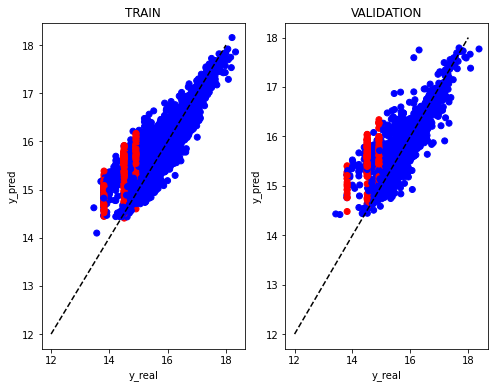

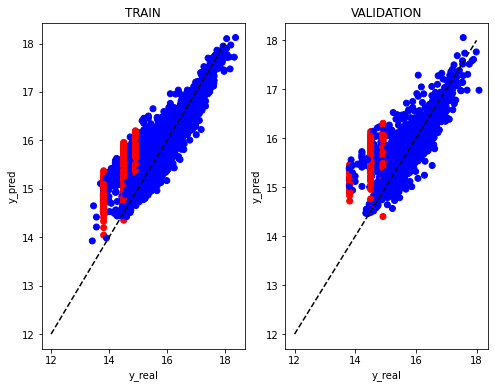

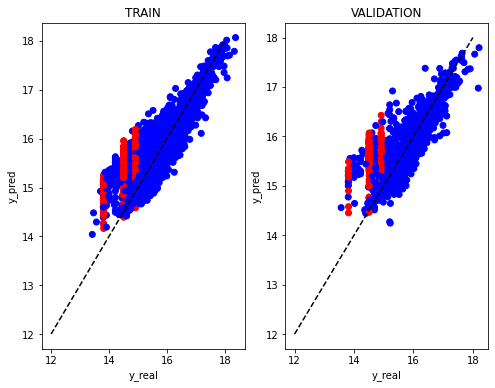

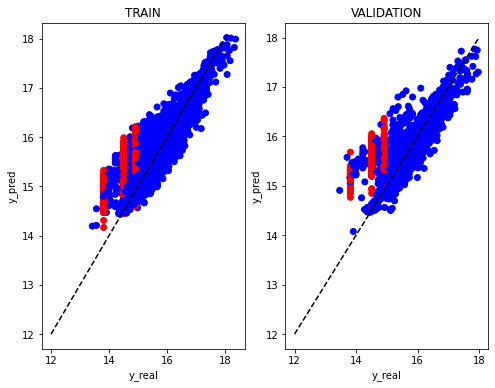

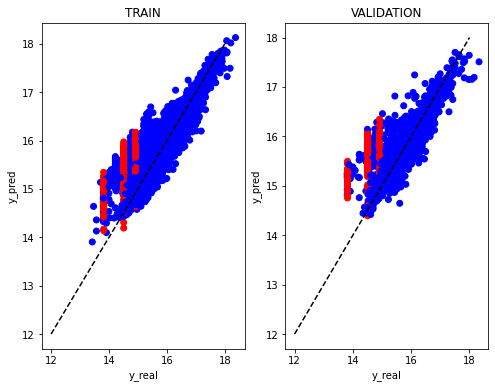

In [134]:
train_errors = []
val_errors = []
kf = KFold(n_splits=5, shuffle=True, random_state=42)
kf_splits = kf.split(X)

for i, (train_index, val_index) in enumerate(kf_splits):
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    # train_errors.append(np.abs(y_pred_train[i] - y_train) / np.abs(y_train))
    # val_errors.append(np.abs(y_pred_val[i] - y_val) / np.abs(y_val))
    train_errors.append(np.square(y_pred_train[i] - y_train))
    val_errors.append(np.square(y_pred_val[i] - y_val))


    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 6))

    mask_fake_prices = (y_train == np.log1p(1_000_000)) | \
                       (y_train == np.log1p(2_000_000)) | \
                       (y_train == np.log1p(3_000_000))
    ax1.scatter(y_train, y_pred_train[i], cmap='bwr', c=mask_fake_prices)
    ax1.plot(np.linspace(12, 18, 100), np.linspace(12, 18, 100), c='black', linestyle='--')
    ax1.set_title('TRAIN')
    ax1.set_xlabel('y_real')
    ax1.set_ylabel('y_pred')

    mask_fake_prices = (y_val == np.log1p(1_000_000)) | \
                       (y_val == np.log1p(2_000_000)) | \
                       (y_val == np.log1p(3_000_000))
    ax2.scatter(y_val, y_pred_val[i], cmap='bwr', c=mask_fake_prices)
    ax2.plot(np.linspace(12, 18, 100), np.linspace(12, 18, 100), c='black', linestyle='--')
    ax2.set_title('VALIDATION')
    ax2.set_xlabel('y_real')
    ax2.set_ylabel('y_pred')

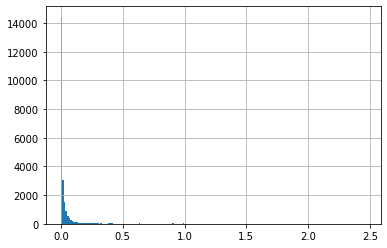

In [136]:
train_errors[0].hist(bins=200);

### `product_type == 'Investment'`

In [147]:
X = train_df.copy()
X = X.drop(idx_outliers_full)

train_df_0 = X[X['product_type'] == 0]

X = train_df_0.drop(['sub_area', 'price_doc'], axis=1).copy()
y = np.log1p(train_df_0['price_doc'])

In [148]:
y_pred_val = []
y_pred_train = []
kf = KFold(n_splits=5, shuffle=True, random_state=42)
kf_splits = kf.split(X)

params = {'objective': 'reg:squarederror',
          'n_estimators': 10000,
          'tree_method': 'gpu_hist',
          'booster': 'gbtree',
          'base_score': 7,
          'learning_rate': 0.05,
          'max_depth': 4,
          'min_child_weight': 7,
          'subsample': 1,
          'colsample_bytree': 0.9,
          'reg_lambda': 5,
          'reg_alpha': 1,
          'eval_metric': 'rmse',
          'seed': 42,
          'nthread': -1
          }

for train_index, val_index in kf_splits:
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    model = XGBRegressor(**params)
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], early_stopping_rounds=50)
    y_pred_train.append(model.predict(X_train))
    y_pred_val.append(model.predict(X_val))

[0]	validation_0-rmse:8.31933	validation_1-rmse:8.32364
[1]	validation_0-rmse:7.90496	validation_1-rmse:7.90925
[2]	validation_0-rmse:7.51139	validation_1-rmse:7.51557
[3]	validation_0-rmse:7.13751	validation_1-rmse:7.14153
[4]	validation_0-rmse:6.78238	validation_1-rmse:6.78639
[5]	validation_0-rmse:6.44510	validation_1-rmse:6.44919
[6]	validation_0-rmse:6.12470	validation_1-rmse:6.12866
[7]	validation_0-rmse:5.82040	validation_1-rmse:5.82433
[8]	validation_0-rmse:5.53136	validation_1-rmse:5.53493
[9]	validation_0-rmse:5.25684	validation_1-rmse:5.26033
[10]	validation_0-rmse:4.99610	validation_1-rmse:4.99923
[11]	validation_0-rmse:4.74847	validation_1-rmse:4.75163
[12]	validation_0-rmse:4.51329	validation_1-rmse:4.51597
[13]	validation_0-rmse:4.28993	validation_1-rmse:4.29268
[14]	validation_0-rmse:4.07785	validation_1-rmse:4.08064
[15]	validation_0-rmse:3.87646	validation_1-rmse:3.87891
[16]	validation_0-rmse:3.68521	validation_1-rmse:3.68763
[17]	validation_0-rmse:3.50358	validation

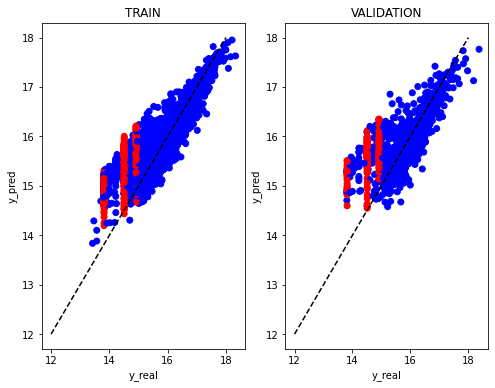

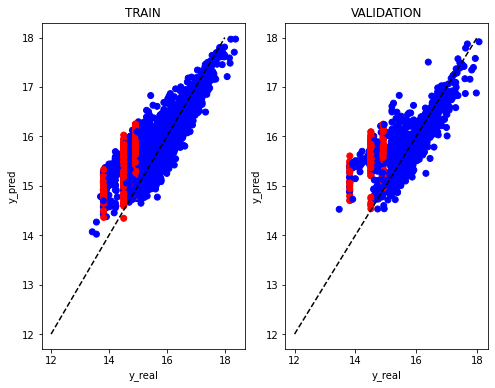

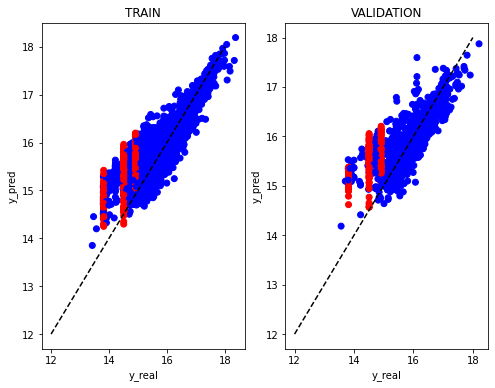

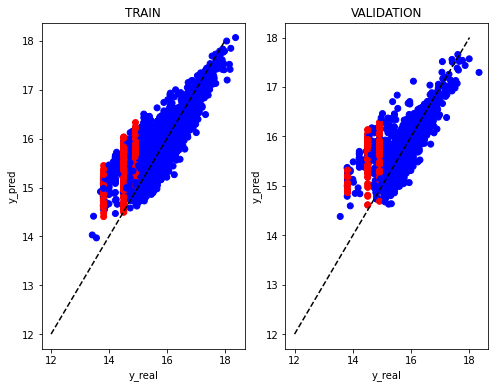

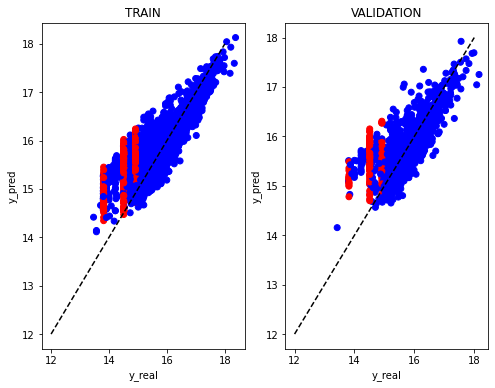

In [149]:
train_errors = []
val_errors = []
kf = KFold(n_splits=5, shuffle=True, random_state=42)
kf_splits = kf.split(X)

for i, (train_index, val_index) in enumerate(kf_splits):
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    # train_errors.append(np.abs(y_pred_train[i] - y_train) / np.abs(y_train))
    # val_errors.append(np.abs(y_pred_val[i] - y_val) / np.abs(y_val))
    train_errors.append(np.square(y_pred_train[i] - y_train))
    val_errors.append(np.square(y_pred_val[i] - y_val))


    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 6))

    mask_fake_prices = (y_train == np.log1p(1_000_000)) | \
                       (y_train == np.log1p(2_000_000)) | \
                       (y_train == np.log1p(3_000_000))
    ax1.scatter(y_train, y_pred_train[i], cmap='bwr', c=mask_fake_prices)
    ax1.plot(np.linspace(12, 18, 100), np.linspace(12, 18, 100), c='black', linestyle='--')
    ax1.set_title('TRAIN')
    ax1.set_xlabel('y_real')
    ax1.set_ylabel('y_pred')

    mask_fake_prices = (y_val == np.log1p(1_000_000)) | \
                       (y_val == np.log1p(2_000_000)) | \
                       (y_val == np.log1p(3_000_000))
    ax2.scatter(y_val, y_pred_val[i], cmap='bwr', c=mask_fake_prices)
    ax2.plot(np.linspace(12, 18, 100), np.linspace(12, 18, 100), c='black', linestyle='--')
    ax2.set_title('VALIDATION')
    ax2.set_xlabel('y_real')
    ax2.set_ylabel('y_pred')

In [158]:
np.savetxt('data/idx_outliers.txt', idx_outliers_full, fmt='%d')

### `product_type == 'OwnerOccupier'`

In [107]:
train_df_1 = train_df[train_df['product_type'] == 1]
test_df_1 = test_df[test_df['product_type'] == 1]

X_1 = train_df_1.drop(['sub_area', 'price_doc'], axis=1).copy()
y_1 = np.log1p(train_df_1['price_doc'])
X_test_1 = test_df_1.drop(['sub_area'], axis=1).copy()

In [ ]:
y_pred_val = []
y_pred_train = []
kf = KFold(n_splits=5, shuffle=True, random_state=42)
kf_splits = kf.split(X_1)

params = {'objective': 'reg:squarederror',
          'n_estimators': 10000,
          'tree_method': 'gpu_hist',
          'booster': 'gbtree',
          'base_score': 7,
          'learning_rate': 0.05,
          'max_depth': 4,
          'min_child_weight': 7,
          'subsample': 1,
          'colsample_bytree': 0.9,
          'reg_lambda': 5,
          'reg_alpha': 1,
          'eval_metric': 'rmse',
          'seed': 42,
          'nthread': -1
          }

for train_index, val_index in kf_splits:
    X_train, X_val = X_1.iloc[train_index], X_1.iloc[val_index]
    y_train, y_val = y_1.iloc[train_index], y_1.iloc[val_index]
    model = XGBRegressor(**params)
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], early_stopping_rounds=50)
    y_pred_train.append(model.predict(X_train))
    y_pred_val.append(model.predict(X_val))

In [ ]:
train_errors = []
val_errors = []
kf = KFold(n_splits=5, shuffle=True, random_state=42)
kf_splits = kf.split(X_1)

for i, (train_index, val_index) in enumerate(kf_splits):
    y_train, y_val = y_1.iloc[train_index], y_1.iloc[val_index]
    # train_errors.append(np.abs(y_pred_train[i] - y_train) / np.abs(y_train))
    # val_errors.append(np.abs(y_pred_val[i] - y_val) / np.abs(y_val))
    train_errors.append(np.square(y_pred_train[i] - y_train))
    val_errors.append(np.square(y_pred_val[i] - y_val))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 6))

    mask_fake_prices = (y_train == np.log1p(1_000_000)) | \
                       (y_train == np.log1p(2_000_000)) | \
                       (y_train == np.log1p(3_000_000))
    ax1.scatter(y_train, y_pred_train[i], cmap='bwr', c=mask_fake_prices)
    ax1.plot(np.linspace(12, 18, 100), np.linspace(12, 18, 100), c='black', linestyle='--')
    ax1.set_title('TRAIN')
    ax1.set_xlabel('y_real')
    ax1.set_ylabel('y_pred')

    mask_fake_prices = (y_val == np.log1p(1_000_000)) | \
                       (y_val == np.log1p(2_000_000)) | \
                       (y_val == np.log1p(3_000_000))
    ax2.scatter(y_val, y_pred_val[i], cmap='bwr', c=mask_fake_prices)
    ax2.plot(np.linspace(12, 18, 100), np.linspace(12, 18, 100), c='black', linestyle='--')
    ax2.set_title('VALIDATION')
    ax2.set_xlabel('y_real')
    ax2.set_ylabel('y_pred')

In [ ]:
train_errors[0].hist(bins=200)

In [ ]:
y_pred_train = np.abs(model_0.predict(X_train_0))
y_pred_val = np.abs(model_0.predict(X_val_0))
print('___________________________________')
print('      RMSLE\n')
print('      TRAIN_1:', np.sqrt(mean_squared_log_error(np.expm1(y_train_0), np.expm1(y_pred_train))))
print(' VALIDATION_1:', np.sqrt(mean_squared_log_error(np.expm1(y_val_0), np.expm1(y_pred_val))))
print('___________________________________')
print('      MAE\n')
print('      TRAIN_1:', mean_absolute_error(np.expm1(y_train_0), np.expm1(y_pred_train)))
print(' VALIDATION_1:', mean_absolute_error(np.expm1(y_val_0), np.expm1(y_pred_val)))

___________________________________
      RMSLE

      TRAIN_1: 0.2297278099989123
 VALIDATION_1: 0.28667372484083364
___________________________________
      MAE

      TRAIN_1: 953739.1728945102
 VALIDATION_1: 1220016.825


In [ ]:
test_df_nan = test_df[test_df['product_type'].isna()]
X_test_nan = test_df_nan.drop(['sub_area'], axis=1).copy()

In [ ]:
submission = pd.read_csv('data/sample_submission.csv', index_col='id')
pred_0 = np.expm1(model_0.predict(X_test_0))
pred_1 = np.expm1(model_1.predict(X_test_1))
pred_nan = np.expm1(model_1.predict(X_test_nan))

if len(pred_0[pred_0 < 0]) or len(pred_1[pred_1 < 0]) or len(pred_nan[pred_nan < 0]):
    print('WARNING: NEGATIVE PREDICTIONS')

In [ ]:
submission.loc[X_test_0.index, 'price_doc'] = 0.9*pred_0
submission.loc[X_test_1.index, 'price_doc'] = 0.93*pred_1
submission.loc[X_test_nan.index, 'price_doc'] = pred_nan
submission.to_csv('submits/submission.csv', index='id')

In [ ]:
!kaggle competitions submit -c sberbank-russian-housing-market -f "submits/submission.csv" -m "XGBRegressor tuned"

100%|████████████████████████████████████████| 121k/121k [00:03<00:00, 40.2kB/s]
Successfully submitted to Sberbank Russian Housing Market

In [ ]:
# !kaggle competitions submissions -c sberbank-russian-housing-market